# Modelado en SciANN para el problema de Burgers

In [4]:
%pip uninstall tensorflow-datasets tensorflow-metadata -y
%pip install tensorflow==2.9
%pip install sciann
%pip install wandb -U

  Using cached SciANN-0.7.0.1-py3-none-any.whl (169 kB)
  Using cached pybtex-0.24.0-py2.py3-none-any.whl (561 kB)
  Using cached latexcodec-3.0.0-py3-none-any.whl (18 kB)


In [5]:
from numpy import pi
import numpy as np
import sciann as sn
from tensorflow import keras
from sciann.utils.math import diff, sign, sin
import matplotlib.pyplot as plt
import time
import pprint
import wandb

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.0 
Python Version: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0] 



## Generación de datos de entrenamiento



In [6]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(0, 1, 100)
)
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200),
    np.linspace(0, 1, 200)
)

## Definición del entorno de experimentación

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'n_layers': {
        'values': [2,4,8]
        },
    'n_in_layer': {
        'values': [20,40]
    },
    'lr': {
        'values': [1,0.1,0.01,0.001]
    },
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'lr': {'values': [1, 0.1, 0.01, 0.001]},
                'n_in_layer': {'values': [20, 40]},
                'n_layers': {'values': [2, 4, 8]}}}


In [ ]:
def sweep_train_burgers(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-2-100"):

          #Definición de entradas
          x = sn.Variable('x')
          t = sn.Variable('t')

          #Definición de la función a aprender
          u = sn.Functional('u', [t,x], wandb.config.n_layers*[wandb.config.n_in_layer], 'tanh')

          #Restricciones del modelo
          L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)
          TOL = 0.001
          C1 = (1-sign(t - TOL)) * (u + sin(pi*x))
          C2 = (1-sign(x - (-1+TOL))) * (u)
          C3 = (1+sign(x - ( 1-TOL))) * (u)

          #Definición del modelo
          burgers_model = sn.SciModel([x, t], [L1, C1, C2, C3])

          start_time = time.time()

          # Entrenamiento.

          burgers_history = burgers_model.train([x_data, t_data],
                                                4*['zero'],
                                                learning_rate=0.01,
                                                epochs=3000)
          train_time = time.time()-start_time

          # Predicción

          start_pred_time = time.time()
          u_pred = u.eval(burgers_model, [x_test, t_test])
          pred_time = time.time() -start_pred_time

          wandb.log(
          {
              'loss': min(burgers_history.history['loss']),
              'train_time': train_time,
              'pred_time': pred_time
          })
          wandb.finish()

In [ ]:
sweep_exp_2_100 = wandb.sweep(sweep_config, project="experimento-2-100")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: m5yycu05
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-2-100/sweeps/m5yycu05


In [ ]:
wandb.agent(sweep_exp_2_100,function=sweep_train_burgers,count=10)

wandb: Agent Starting Run: dst6qye9 with config:
wandb: 	lr: 0.01
wandb: 	n_in_layer: 40
wandb: 	n_layers: 8
wandb: Currently logged in as: vaatiper (vaatiper-Universidad de Granada). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Epoch 509/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0227 - sub_loss: 4.6126e-33 - mul_3_loss: 0.0213 - mul_4_loss: 7.9985e-04 - mul_5_loss: 6.2012e-04 - lr: 0.0050 - time: 1.7270
Epoch 510/3000
157/157 [==============================] - 1s 9ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0218 - sub_loss: 4.3590e-33 - mul_3_loss: 0.0203 - mul_4_loss: 5.9422e-04 - mul_5_loss: 8.8479e-04 - lr: 0.0050 - time: 1.4058
Epoch 511/3000
157/157 [==============================] - 1s 9ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0213 - sub_loss: 4.0675e-33 - mul_3_loss: 0.0198 - mul_4_loss: 7.8567e-04 - mul_5_loss: 7.6430e-04 - lr: 0.0050 - time: 1.3777
Epoch 512/3000
157/157 [==============================] - 1s 9ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0220 - sub_loss: 3.2473e-33 - mul_3_loss: 0.0210 - mul_4_loss: 5.2684e-04 - mul_5_loss: 5.1430e-04 - lr: 0.0050 - t

loss,▁
pred_time,▁
train_time,▁
loss,0.0119
pred_time,0.55567
train_time,5858.41008


wandb: Agent Starting Run: ax5fn39l with config:
wandb: 	lr: 0.001
wandb: 	n_in_layer: 20
wandb: 	n_layers: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Epoch 509/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0216 - sub_4_loss: 3.2570e-20 - mul_9_loss: 0.0204 - mul_10_loss: 4.7276e-04 - mul_11_loss: 6.5334e-04 - lr: 0.0050 - time: 1.5135
Epoch 510/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0224 - sub_4_loss: 3.6810e-20 - mul_9_loss: 0.0213 - mul_10_loss: 5.6596e-04 - mul_11_loss: 5.0209e-04 - lr: 0.0050 - time: 1.5123
Epoch 511/3000
157/157 [==============================] - 2s 9ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0209 - sub_4_loss: 2.9899e-20 - mul_9_loss: 0.0201 - mul_10_loss: 4.4644e-04 - mul_11_loss: 4.3434e-04 - lr: 0.0050 - time: 1.5496
Epoch 512/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0238 - sub_4_loss: 4.4320e-20 - mul_9_loss: 0.0220 - mul_10_loss: 8.5146e-04 - mul_11_loss: 9.1610e-0

loss,▁
pred_time,▁
train_time,▁
loss,0.01371
pred_time,0.33035
train_time,5030.89966


wandb: Agent Starting Run: ks8a2qdg with config:
wandb: 	lr: 0.01
wandb: 	n_in_layer: 20
wandb: 	n_layers: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Streaming output truncated to the last 5000 lines.
Epoch 509/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0212 - sub_8_loss: 1.2717e-33 - mul_15_loss: 0.0207 - mul_16_loss: 2.5194e-04 - mul_17_loss: 2.8183e-04 - lr: 0.0050 - time: 1.5488
Epoch 510/3000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0217 - sub_8_loss: 1.6277e-33 - mul_15_loss: 0.0206 - mul_16_loss: 4.5108e-04 - mul_17_loss: 6.5515e-04 - lr: 0.0050 - time: 1.6173
Epoch 511/3000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0219 - sub_8_loss: 1.0798e-33 - mul_15_loss: 0.0208 - mul_16_loss: 6.1008e-04 - mul_17_loss: 5.4328e-04 - lr: 0.0050 - time: 1.7041
Epoch 512/3000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0216 - sub_8_loss: 1.4237e-33 - mul_15_loss: 0.0203 - mul_16_loss: 7.0715e-04 - mul_17_loss: 5.73

loss,▁
pred_time,▁
train_time,▁
loss,0.0099
pred_time,0.28604
train_time,5143.91721


wandb: Agent Starting Run: bwa8r1lp with config:
wandb: 	lr: 0.001
wandb: 	n_in_layer: 20
wandb: 	n_layers: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 10000 
Batch size: 64 
Total batches: 157 

Epoch 1/3000
157/157 [==============================] - 7s 12ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0251 - sub_12_loss: 0.0049 - mul_21_loss: 0.0171 - mul_22_loss: 0.0016 - mul_23_loss: 0.0014 - lr: 0.0100 - time: 7.1227
Epoch 2/3000
157/157 [==============================] - 2s 12ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0187 - sub_12_loss: 8.6960e-04 - mul_21_loss: 0.0154 - mul_22_loss: 0.0016 - mul_23_loss: 8.6643e-04 - lr: 0.0100 - time: 1.8560
Epoch 3/3000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0164 - sub_12_loss: 6.6961e-04 - mul_21_loss: 0.0134 - mul_22_loss: 0.0012 - mul_23_loss: 0.0011 - lr: 0.0100 - time: 1.8194
Epoch 4/3000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0156 - sub_12_loss: 4.8156e-04 - mul_21_loss: 0.0128 - mul_22_loss: 0.0011 - mul_23_loss: 0.0012 - lr: 0.0100 - time:

## Selección de modelos

In [ ]:
#Definición de entradas
x = sn.Variable('x')
t = sn.Variable('t')

#Definición de la función a aprender
u = sn.Functional('u', [t,x], 8*[20], 'tanh')

#Restricciones del modelo
L1 = diff(u, t) + u*diff(u,x) - (0.01/pi)*diff(u, x, order=2)
TOL = 0.001
C1 = (1-sign(t - TOL)) * (u + sin(pi*x))
C2 = (1-sign(x - (-1+TOL))) * (u)
C3 = (1+sign(x - ( 1-TOL))) * (u)

#Definición del modelo
burgers_model = sn.SciModel([x, t], [L1, C1, C2, C3], plot_to_file='burgers.png')

burgers_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 t (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 x (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 concat (Concatenate)           (None, 2)            0           ['t[0][0]',                      
                                                                  'x[0][0]']                      
                                                                                                  
 D20b (Dense)                   (None, 20)           60          ['concat[0][0]']             

In [ ]:
x_data, t_data = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(0, 1, 100)
)

In [ ]:
start_time = time.time()
burgers_history = burgers_model.train([x_data, t_data],
                                      4*['zero'],
                                      learning_rate=0.002,
                                      epochs=5000,
                                      callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)])

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")


Total samples: 10000 
Batch size: 64 
Total batches: 157 

Epoch 1/5000
157/157 [==============================] - 3s 16ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0068 - sub_loss: 0.0017 - mul_4_loss: 0.0049 - mul_5_loss: 4.9728e-05 - mul_6_loss: 7.0511e-05 - lr: 0.0020 - time: 2.5887
Epoch 2/5000
157/157 [==============================] - 3s 17ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0068 - sub_loss: 0.0016 - mul_4_loss: 0.0051 - mul_5_loss: 4.9792e-05 - mul_6_loss: 4.3277e-05 - lr: 0.0020 - time: 2.6094
Epoch 3/5000
157/157 [==============================] - 1s 7ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0236 - sub_loss: 0.0074 - mul_4_loss: 0.0140 - mul_5_loss: 0.0015 - mul_6_loss: 7.1796e-04 - lr: 0.0020 - time: 1.1431
Epoch 4/5000
157/157 [==============================] - 2s 10ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0160 - sub_loss: 7.4834e-04 - mul_4_loss: 0.0128 - mul_5_loss: 0.0017 - mul_6_loss: 7.8125e-04 - lr: 0.0020 - time: 1.6440
Epoch

In [ ]:
start_time = time.time()
burgers_entrenamiento_completo = burgers_model.train([x_data, t_data],
                                      4*['zero'],
                                      learning_rate=0.002,
                                      epochs=5000)

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

Se han truncado las últimas 5000 líneas del flujo de salida.
157/157 [==============================] - 2s 13ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0063 - sub_loss: 0.0011 - mul_4_loss: 0.0051 - mul_5_loss: 5.4817e-06 - mul_6_loss: 3.2223e-05 - lr: 0.0010 - time: 2.1635
Epoch 2503/5000
157/157 [==============================] - 2s 13ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0050 - sub_loss: 4.1032e-04 - mul_4_loss: 0.0046 - mul_5_loss: 1.3730e-06 - mul_6_loss: 9.3631e-07 - lr: 0.0010 - time: 2.1105
Epoch 2504/5000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0049 - sub_loss: 5.2633e-04 - mul_4_loss: 0.0044 - mul_5_loss: 5.1459e-06 - mul_6_loss: 2.7798e-06 - lr: 0.0010 - time: 1.7079
Epoch 2505/5000
157/157 [==============================] - 2s 11ms/step - batch: 78.0000 - size: 63.6943 - loss: 0.0050 - sub_loss: 9.2588e-04 - mul_4_loss: 0.0041 - mul_5_loss: 8.1556e-06 - mul_6_loss: 5.2484e-06 - lr: 0.0010 - time

Text(0, 0.5, 'Pérdida')

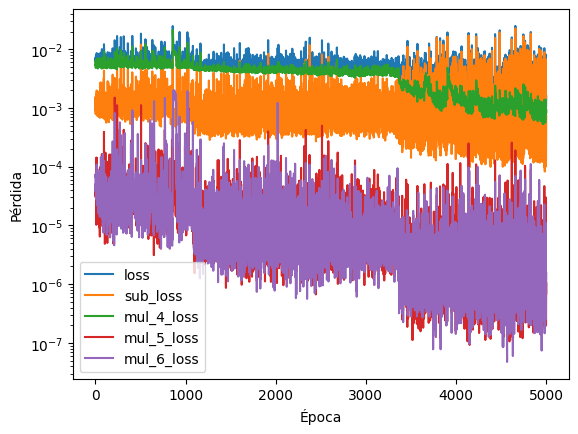

In [ ]:
plt.semilogy(burgers_entrenamiento_completo.history['loss'],label="loss")
plt.semilogy(burgers_entrenamiento_completo.history['sub_loss'],label='sub_loss')
plt.semilogy(burgers_entrenamiento_completo.history['mul_4_loss'],label='mul_4_loss')
plt.semilogy(burgers_entrenamiento_completo.history['mul_5_loss'],label='mul_5_loss')
plt.semilogy(burgers_entrenamiento_completo.history['mul_6_loss'],label='mul_6_loss')

plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

In [ ]:
x_test, t_test = np.meshgrid(
    np.linspace(-1, 1, 200),
    np.linspace(0, 1, 200)
)
u_pred = u.eval(burgers_model, [x_test, t_test])

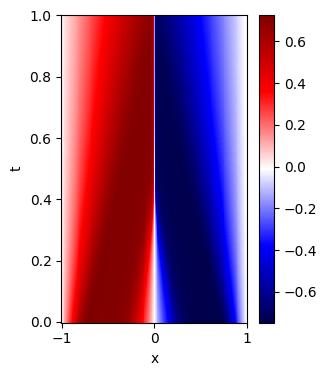

In [ ]:
fig = plt.figure(figsize=(3, 4))
plt.pcolor(x_test, t_test, u_pred, cmap='seismic')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()